# CIFAR10 Classification

In this part of the assignment we want to do an image classification task using PyTorch on CIFAR10 dataset.

## Import Libraries

Import needed libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.utils.data as ut
import random
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import torchvision
import torchvision.transforms as transforms
from matplotlib import pyplot
print('libraries imported')

libraries imported


## Device

Set device to work with (GPU or CPU)

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Transforms & Dataset & Dataloader

Here, you should download and load the dataset with the desire transforms. After that, you should split train dataset to train and validation sets. Finally, define the dataloaders for `train`, `validation` and `test`

In [4]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [5]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

transform_visual = transforms.Compose([
    transforms.ToTensor(),
])


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

featureset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
featureset_nm = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_test)



visualset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_visual)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    
validset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_test)

testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)
    
featureloader = torch.utils.data.DataLoader(featureset, batch_size=100, shuffle=False, num_workers=2)    
featureloader_nm = torch.utils.data.DataLoader(featureset_nm, batch_size=100, shuffle=False, num_workers=2)   
    
index_list = list(range(len(trainset)))
np.random.shuffle(index_list)

trainset_sampler = ut.SubsetRandomSampler(index_list[ int(np.floor(0.15 * len(trainset))):])
validationset_sampler = ut.SubsetRandomSampler(index_list[: int(np.floor(0.15 * len(trainset)))])

trainloader = torch.utils.data.DataLoader(
    trainset, sampler=trainset_sampler, batch_size=128, num_workers=4)
validloader = torch.utils.data.DataLoader(
    validset, sampler=validationset_sampler, batch_size=128, num_workers=4)    

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


## Visualization

Visualize 5 random images from each class in different columns

- **Hint**:  You can use `plt.subplots` for visualization

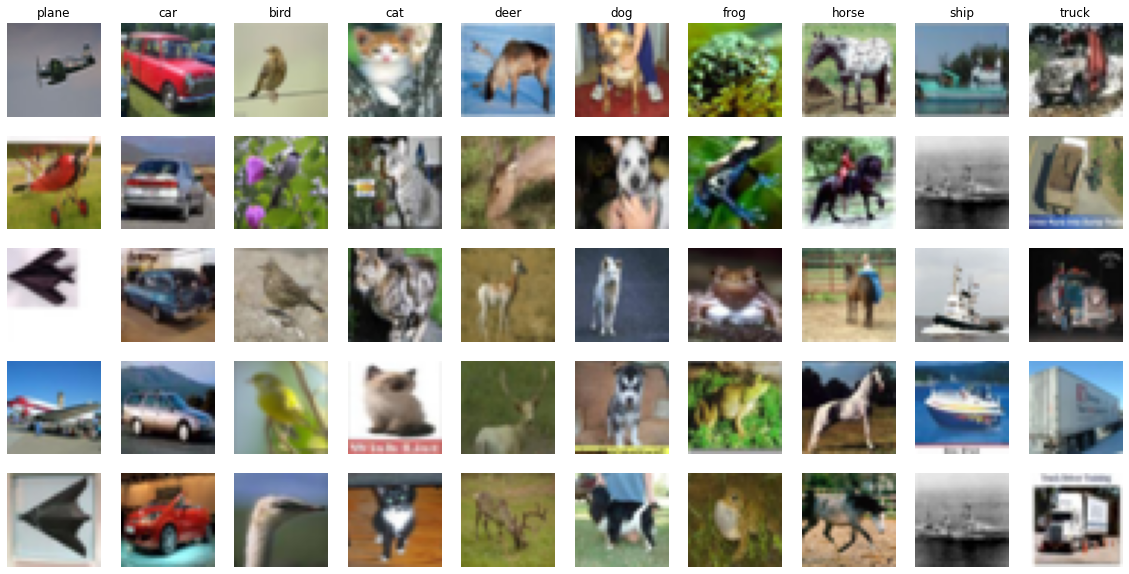

In [186]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 10))

for i in range(50):
    fig.add_subplot(5, 10, i + 1)
    label = 100
    while label != i % 10: 
        image, label = visualset[random.randrange(1000)]
    plt.imshow(image.permute(1, 2, 0).numpy())
    if 0 <= i <=9 : 
        plt.title(classes[label])   
    plt.axis('off')

## Model

Define your model here from scratch (You are not allowed to use the existing models in pytorch)

**NOTICE:** The model that you will have defined outputs a vector containing 10 numbers (for each class). Define a "feature space" that is a vector of size *N* (where *N > 10*) right before the last layer (You can then have a last layer like `nn.Linear(N, 10)`). See the image below to get a better understanding. We will use this later (we want to access the feature space of a sample when the sample is given to the model). The model tries to learn a representation of the samples in this feature space and we will see how good it could do this in later sections.

![Feature Space In Neural Network](https://i.postimg.cc/28Qjcn9D/feature-space-vis.png)

- **Hint I**: Our goal is to get accuracy above *90%* on testset. Our suggestion is to implement ResNet (ResNet18 could be a viable choice)
  - You can learn the network's structure and implementation online (Youtube, ...) and then implmenet it yourself and make changes to enhance it's performance on our task **(YOU SHOULD NOT COPY THE CODE!!! OTHERWISE, YOU'LL BE PENALIZED!!!)**

- **Hint II**: When defining your model, pay attension to the **NOTICE** part in the above. It's also better to read the "Exploring the feature space" section beforehand.  

In [6]:
class RN18B(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(RN18B, self).__init__()
        self.first_convolution = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.first_batchnorm = nn.BatchNorm2d(planes)
        self.second_convolution = nn.Conv2d(planes, planes, kernel_size=3,stride=1, padding=1, bias=False)
        self.second_batchnorm = nn.BatchNorm2d(planes)

        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )
        else:    
            self.shortcut = nn.Sequential()

    def forward(self, x):
           return F.relu(self.second_batchnorm(self.second_convolution(F.relu(self.first_batchnorm(self.first_convolution(x))))) + self.shortcut(x))
         
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.first_layer = self.layer(64, 1)
        self.second_layer = self.layer(128, 2)
        self.third_layer = self.layer(256, 2)
        self.forth_layer = self.layer(512, 2)
        self.conv = nn.Conv2d(3, 64, kernel_size=3,stride=1, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(64)
        self.fc = nn.Linear(512, 64)
        self.fc2 = nn.Linear(64, 10)
        

    def layer(self, planes, stride):
        strides = [stride] + [1]
        layers = []
        for stride in strides:
            layers.append(RN18B(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.avg_pool2d( self.forth_layer(self.third_layer(self.second_layer(self.first_layer(F.relu(self.bn(self.conv(x))))))), 4)
        x = x.view(x.size(0), -1)
        x = self.fc2(self.fc(x))
        return x


## Train

### Model instantiation

Create an instance of your model and move it to `device`

In [7]:
net = ResNet()
net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

### Criterion & Optimizater

Define `criterion` and `optimizer` (Or `scheduler`)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

### Train loop

Train your model 

Tasks:
- [ ] Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Train accuracy
  - Validation loss
  - Validation accuracy
- [ ] save train/validation loss and accuracy (of each epoch) in an array for later usage

In [15]:
best_acc = 0 
train_losses = []
val_loss = []
train_acc = []
val_acc = []
for epoch in range(80):
    net.train()
    train_loss = correct = total =  0
    for batch, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    print(epoch, 'Train Loss: %.3f |Train Acc: %.3f%% (%d/%d)' % (train_loss/(batch+1), 100.*correct/total, correct, total)) 
    train_acc.append(100.*correct/total)
    train_losses.append(train_loss)
    net.eval()
    test_loss = correct = total =  0
    with torch.no_grad():
        for batch, (inputs, targets) in enumerate(validloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    print(epoch, 'Validation Loss: %.3f |Validation Acc: %.3f%% (%d/%d)'  % (test_loss/(batch+1), 100.*correct/total, correct, total))        
    val_acc.append(100.*correct/total)
    val_loss.append(test_loss)
    
    scheduler.step()

0 Train Loss: 0.967 |Train Acc: 65.551% (27859/42500)
0 Validation Loss: 1.680 |Validation Acc: 53.080% (3981/7500)
1 Train Loss: 0.762 |Train Acc: 73.162% (31094/42500)
1 Validation Loss: 0.776 |Validation Acc: 73.520% (5514/7500)
2 Train Loss: 0.655 |Train Acc: 77.435% (32910/42500)
2 Validation Loss: 0.646 |Validation Acc: 77.880% (5841/7500)
3 Train Loss: 0.568 |Train Acc: 80.275% (34117/42500)
3 Validation Loss: 0.596 |Validation Acc: 79.560% (5967/7500)
4 Train Loss: 0.505 |Train Acc: 82.454% (35043/42500)
4 Validation Loss: 0.561 |Validation Acc: 81.160% (6087/7500)
5 Train Loss: 0.477 |Train Acc: 83.487% (35482/42500)
5 Validation Loss: 0.574 |Validation Acc: 81.373% (6103/7500)
6 Train Loss: 0.426 |Train Acc: 85.231% (36223/42500)
6 Validation Loss: 0.505 |Validation Acc: 83.227% (6242/7500)
7 Train Loss: 0.388 |Train Acc: 86.649% (36826/42500)
7 Validation Loss: 0.537 |Validation Acc: 83.160% (6237/7500)
8 Train Loss: 0.367 |Train Acc: 87.395% (37143/42500)
8 Validation Loss:

### Visualize Loss and Accuracy plot

Using the arrays that you have (from task 2 in the above section), visualize two plots: Accuracy plot (train and validation together) and Loss plot (train and validation together)

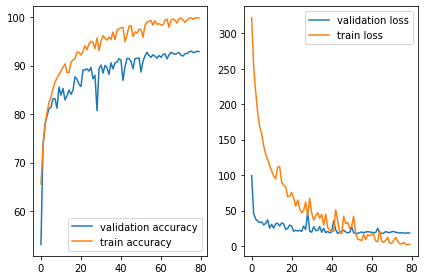

In [18]:
import matplotlib.pyplot as plt
  
plt.subplot(1, 2, 1)
plt.plot(val_acc, label = "validation accuracy")
plt.plot(train_acc, label = "train accuracy")
plt.tight_layout()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_loss, label = "validation loss")
plt.plot(train_losses, label = "train loss")

plt.tight_layout()
plt.legend()
plt.show()

## Evaluation

Test your trained model (using the Test Dataloader that you have). Our goal is to reach an accuracy above `90%`

In [11]:
net.eval()
test_loss = 0
correct = 0
total = 0
wrongs = {}

denorm_detest = transforms.Compose([
    transforms.Normalize((0, 0, 0), (1./0.2023, 1./0.1994, 1./0.2010)),
    transforms.Normalize((-0.4914, -0.4822, -0.4465), (1., 1., 1.)),
])


with torch.no_grad():
        for batch, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()   
            
            for i in range(len(predicted)):
                if predicted[i] != targets[i]:
                    im = inputs[i]
                    im.cpu()
                    wrongs[classes[targets[i]] + " -> " + classes[predicted[i]]] = denorm_detest(im.cpu()).permute(1, 2, 0).numpy()
                    
print(100.*correct/total)            
print( correct,'/' , total)
            

92.5
9250 / 10000


## Visualize incorrectly predicted samples from testset

Visualize *24* random images from testset that are incorrectly predicted by the model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


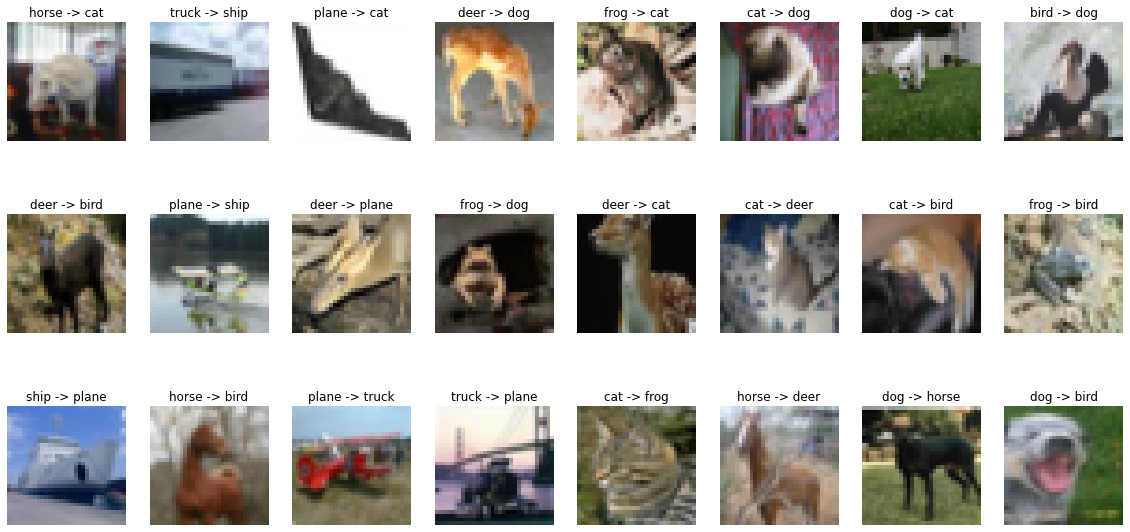

In [13]:
import matplotlib.pyplot as plt
pic_index = 1
fig = plt.figure(figsize=(20, 10))
for title in wrongs.keys():
        image = wrongs[title]
        fig.add_subplot(3, 8, pic_index)
        plt.imshow(image)
        plt.title(title)   
        plt.axis('off')
        pic_index += 1
        if pic_index == 25:
            break

In [ ]:
torch.save(net.state_dict(), 'bestnet2')

In [9]:
net.load_state_dict(torch.load('bestnet2'))

<All keys matched successfully>

## Exploring the feature space

### Calculate the feature space for all training samples

You have trained and evaluated your model. Now, for each sample in the trainset, calculate it's "feature space" discussed in the model section. The result of this section should be a tensor of size `(50000, N)` saved in a variable (for later usage)

- **Hint 1:** define a tensor with dimension `(50000, N)` where *50000* is the size of the trainset and *N* is the dimension of the feature space

- **Hint 2:** Pay attension to the `shuffle` attribute of your train dataloader (If needed)

In [15]:
feature_space = []
test_labels = []
n = True
normal_feature_space = []
def get_features(s , i , o):
    if n:
        feature_space.extend(i[0].cpu().numpy())
    else:
        normal_feature_space.extend(i[0].cpu().numpy())

handle = net.module.fc2.register_forward_hook(get_features)

In [16]:
net.eval()
with torch.no_grad():
        for (inputs, targets) in featureloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
        n = False        
        for (inputs, targets) in featureloader_nm:
            inputs, targets = inputs.to(device), targets.to(device)
            test_labels.extend([x.item() for x in targets])
            outputs = net(inputs)    
                    
feature_space = torch.FloatTensor(feature_space)
feature_space = feature_space.to(device)
normal_feature_space = torch.FloatTensor(normal_feature_space)
normal_feature_space = normal_feature_space.to(device)
print(feature_space.shape)
print(normal_feature_space.shape)

/tmp/ipykernel_32/882472051.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  feature_space = torch.FloatTensor(feature_space)


torch.Size([50000, 64])
torch.Size([50000, 64])


In [17]:
handle.remove()

### K Nearest Neighbor in feature space

You already have calculated the feature spaces for trainset ($S$) in the previous section

1. Get 5 random samples from testset which are correctly predicted by the model. 
2. for each sample, calculate it's "feature space" ($X$)
3. for each sample, calculate it's *5* nearest neighbors in "feature space" in the trainset (by comparing $X$ to each row in $S$) and visualize them

**Note:** Your visualization should be something like the below picture

**Hint:** For finding the nearest neighbors in the feature space you can use `torch.linalg.norm` and `torch.topk`

In [ ]:
test_feature_space = []
def get_test_features(s , i , o):
    test_feature_space.extend(i[0].cpu().numpy())
    
handle = net.module.fc2.register_forward_hook(get_test_features)

In [ ]:
net.eval()
corrects = []

with torch.no_grad():
        for batch, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            labels, predicted = outputs.max(1)
            
            for i in range(len(predicted)):
                if predicted[i] == targets[i]:
                    im = inputs[i]
                    im.cpu()
                    corrects.append(im)

                    
indexes = np.random.randint(low = 0, high = 10000, size = 5)       

random_five = []
random_five_features = []
for index in indexes:
    random_five.append(corrects[index])   
    random_five_features.append(test_feature_space[index])

In [ ]:
handle.remove()
random_five_features = torch.FloatTensor(random_five_features)
random_five_features = random_five_features.to(device)

In [103]:
knn = [None for _ in range(5)]
for i in range(5):
    dist = torch.norm(random_five_features[i] - feature_space, dim=1)
    knn[i] = dist.topk(5, largest=False).indices

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


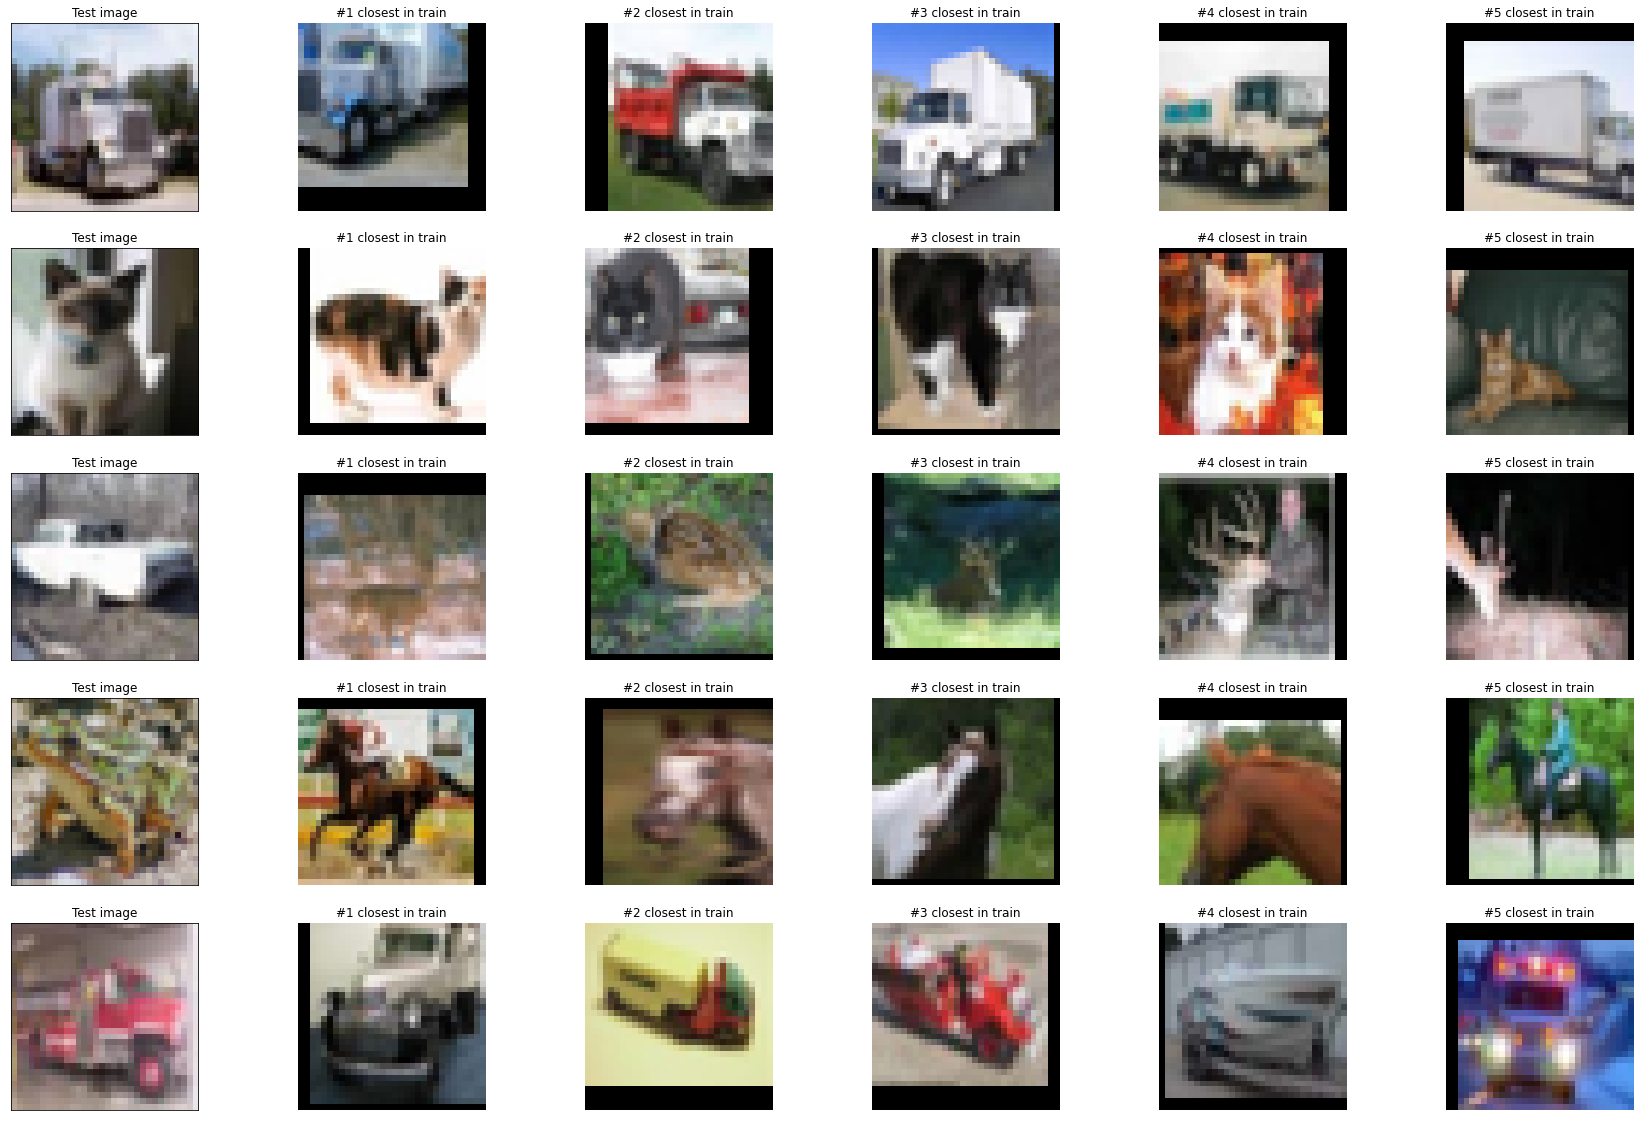

In [113]:
fig = plt.figure(figsize=(30, 20))
image_index = 0
for i in range(5):
    plts = fig.add_subplot(5, 6, image_index + 1, xticks=[], yticks=[])
    plt.imshow(np.transpose(denorm_detest(random_five[i]).cpu(),(1, 2, 0)))
    plts.set_title('Test image')
    image_index += 1
    for j in range(5):
        plts = fig.add_subplot(5, 6, image_index + 1)
        plt.imshow(np.transpose(visualset[knn[i][j]][0].cpu().numpy(), (1, 2, 0)))
        plt.axis('off')
        plts.set_title(f'#{j + 1} closest in train')
        image_index += 1
    

### TSNE 

1. Sample $M$ ($2000$ would be enought) random samples from the trainset feature space (calculated in the above sections) 
2. Now you a vector of size `(M, N)` where $N$ is the dimension of the feature space
3. Using TSNE reduce $N$ to $2$ (Now you have a vector of size `(M, 2)`)
4. Print the shape of the output

**Hint:** You can use `sklearn.manifold.TSNE`

In [18]:
random_indexes = np.random.choice(np.arange(50000), 2000)

part = normal_feature_space[random_indexes]
part2 = TSNE(n_components=2, perplexity=60, n_iter=20000, init='random', learning_rate=5).fit_transform(part.cpu())
print(part2.shape)

(2000, 2)


Visualize the points in a 2D plane (Set color of each point based on it's class)

**Notice:** Your visualization should be something like the below image

**Hint:** Use `plt.scatter(x, y, c=labels)`

torch.Size([50000])


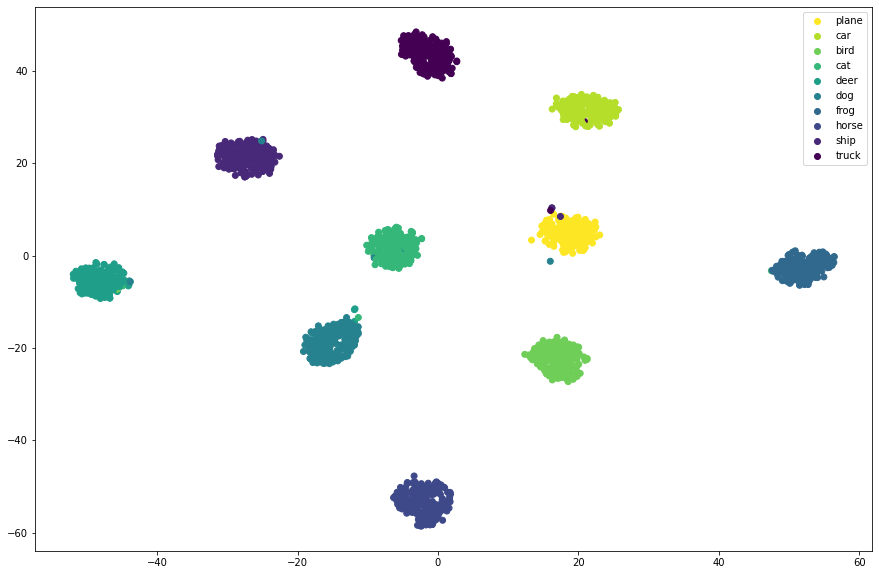

In [20]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import random

fig = plt.figure(figsize=(15, 10))

l = torch.FloatTensor(test_labels)
print(l.shape)
scatter = plt.scatter(part2[:,0], part2[:, 1], c=l[random_indexes], cmap='viridis_r')

plt.legend(handles=scatter.legend_elements()[0], labels=classes)


# CIFAR10 Colorization

In this part of the assignment, we want to do an image colorization task using PyTorch on CIFAR10 dataset. We want to train a model that colors  a black-and-white image.

## Import Libraries

Import needed libraries

In [35]:
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
import matplotlib.pyplot as plt

device(type='cuda')

## Custom Dataset

Define a custom dataset class by extensing `torch.utils.data.Dataset`

**Notice:** your dataset should output two things: black-and-white image and the RGB image

**Hint:** You don't have to reinvent the wheel. Your class should just be a wrapper for CIFAR10 dataset

In [78]:
class BlackAndWitheCIFAR10(CIFAR10):
    def __getitem__(self, index):
        im, _ = super().__getitem__(index)
        return im,  transforms.functional.rgb_to_grayscale(im, num_output_channels=3) , _

## Transforms & Dataset & Dataloader

**Notice:** Use your defined custom dataset class for defining the datasets

In [79]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([transforms.ToTensor(),])

trainset = BlackAndWitheCIFAR10('./data', transform=transform_train, train=True, download=True)
testset = BlackAndWitheCIFAR10('./data', train=False, download=True, transform=transform_test)

index_list = list(range(len(trainset)))
np.random.shuffle(index_list)

trainset_sampler = SubsetRandomSampler(index_list[int(np.floor(0.15 * len(trainset))):])
validationset_sampler = SubsetRandomSampler(index_list[:int(np.floor(0.15 * len(trainset)))])


train_loader = DataLoader(trainset, batch_size=128,sampler=trainset_sampler, num_workers=4)
valid_loader = DataLoader(trainset, batch_size=128, sampler=validationset_sampler, num_workers=4)
test_loader = DataLoader(testset, batch_size=128, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


## Dataset Visualization

Visualize your dataset (black-and-white image along with the RGB image) by sampling from your trainset

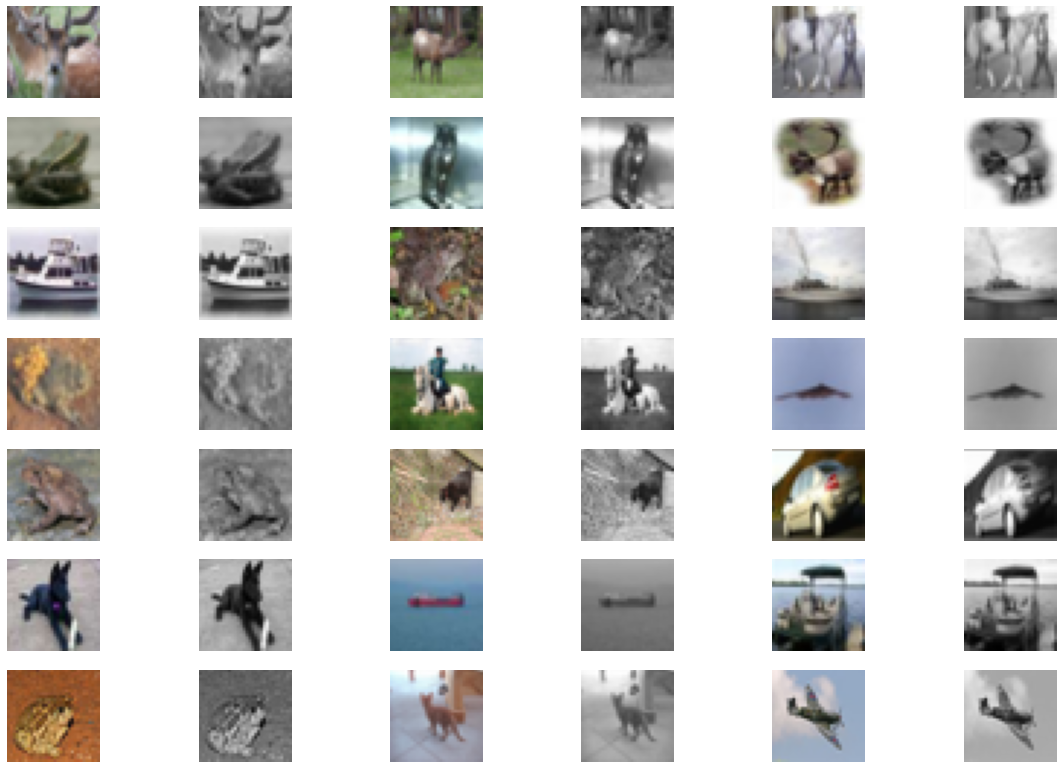

In [39]:
colored_images, black_and_white_images, _ = iter(train_loader).next()
colored_images, black_and_white_images = colored_images.numpy(), black_and_white_images.numpy() 

fig = plt.figure(figsize=(20, 20))

for idx in range(0, 42, 2):
    plt.subplot(10, 6, idx+1)
    plt.axis('off')
    plt.imshow(np.transpose(colored_images[idx], (1, 2, 0)))
    plt.subplot(10, 6, idx+2)
    plt.axis('off')
    plt.imshow(np.transpose(black_and_white_images[idx], (1, 2, 0)))
         

## Model

Define your model here (Input: black-and-white image, Output: RGB image)

**Hint:** You can implement an autoencoder that does the colorization task for you. UNet could be a viable option 

In [77]:
class CCNN(nn.Module):
    def __init__(self):
        super(CCNN, self).__init__()
        
        self.first_conv = nn.Conv2d(3, 32, kernel_size = 2, stride = 2, padding = 1) # 32 * 17 * 17
        self.first_batchnorm = nn.BatchNorm2d(32)
                
        self.second_conv = nn.Conv2d(32, 64, kernel_size = 3, stride = 2, padding = 1) # 64 * 9 * 9
        self.second_batchnorm = nn.BatchNorm2d(64)
        
        self.third_conv = nn.Conv2d(64, 128, kernel_size = 4, stride = 1) # 128 * 6 * 6
        self.third_batchnorm = nn.BatchNorm2d(128)
        
        self.forth_conv = nn.Conv2d(128, 256, kernel_size = 3, stride = 1) # 256 * 4 * 4
        self.forth_batchnorm = nn.BatchNorm2d(256)
        
        self.fifth_conv = nn.Conv2d(256, 512, kernel_size = 3, stride = 1) # 512 * 2 * 2
        self.fifth_batchnorm = nn.BatchNorm2d(512)
        
        self.first_conv_inverse = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1) #  256 * 4 * 4
        self.sixth_batchnorm = nn.BatchNorm2d(256)
        
        self.second_conv_inverse = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1) #  128 * 8 * 8
        self.seventh_batchnorm = nn.BatchNorm2d(128)
        
        self.third_conv_inverse = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1) #  64 * 16 * 16
        self.eightth_batchnorm = nn.BatchNorm2d(64)
        
        self.forth_conv_inverse = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=2) #  32 * 30 * 30
        self.ninth_batchnorm = nn.BatchNorm2d(32)
        
        self.last_conv_inverse = nn.ConvTranspose2d(32, 3, kernel_size=3, stride=1) #  3 * 32 * 32

    def forward(self, x):
        x = F.relu(self.first_batchnorm(self.first_conv(x)))
        x = F.relu(self.second_batchnorm(self.second_conv(x)))
        x = F.relu(self.third_batchnorm(self.third_conv(x)))
        x = F.relu(self.forth_batchnorm(self.forth_conv(x)))
        x = F.relu(self.fifth_batchnorm(self.fifth_conv(x)))
        x = F.relu(self.sixth_batchnorm(self.first_conv_inverse(x)))
        x = F.relu(self.seventh_batchnorm(self.second_conv_inverse(x)))
        x = F.relu(self.eightth_batchnorm(self.third_conv_inverse(x)))
        x = F.relu(self.ninth_batchnorm(self.forth_conv_inverse(x)))
        x = self.last_conv_inverse(x)

        return x



## Train

Train your model

Tasks:
- [ ] Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Validation loss
- [ ] save train/validation loss (of each epoch) in an array for later usage

In [27]:
cn = CCNN()
cn = cn.to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(cn.parameters(), lr=0.0025,momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

In [43]:
training_loss = []
validation_loss = []

for epoch in range(100):
    cn.train()
    for colorfull_images, bw_images, _ in train_loader:
        
        bw_images , colorfull_images = bw_images.to(device), colorfull_images.to(device)
        result = cn(bw_images)
        loss = criterion(result, colorfull_images)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()        
        training_loss.append(loss.item())
    print('Epoch ' ,epoch , '  Training Loss is '  , loss.item() )
    cn.eval()
    for (colorfull_images, bw_images, _) in valid_loader:
        bw_images, colorfull_images = bw_images.to(device), colorfull_images.to(device)
        result = cn(bw_images)
        loss = criterion(result, colorfull_images)
        validation_loss.append(loss.item())
        
    scheduler.step()
    print('Epoch ' ,epoch , '  Validation Loss is '  , loss.item() )


Epoch  0   Training Loss is  0.013653194531798363
Epoch  0   Validation Loss is  0.01487424410879612
Epoch  1   Training Loss is  0.050376489758491516
Epoch  1   Validation Loss is  0.012706415727734566
Epoch  2   Training Loss is  0.02062920480966568
Epoch  2   Validation Loss is  0.012839535251259804
Epoch  3   Training Loss is  0.019220996648073196
Epoch  3   Validation Loss is  0.012478209100663662
Epoch  4   Training Loss is  0.0149398697540164
Epoch  4   Validation Loss is  0.011753847822546959
Epoch  5   Training Loss is  0.01885611191391945
Epoch  5   Validation Loss is  0.011619705706834793
Epoch  6   Training Loss is  0.016422245651483536
Epoch  6   Validation Loss is  0.011310593225061893
Epoch  7   Training Loss is  0.025309205055236816
Epoch  7   Validation Loss is  0.010724998079240322
Epoch  8   Training Loss is  0.015028955414891243
Epoch  8   Validation Loss is  0.012592310085892677
Epoch  9   Training Loss is  0.010354923084378242
Epoch  9   Validation Loss is  0.0144

### Visualize Loss plot

Using the arrays that you have (from task 2 in the above section), visualize the loss plot (train and validation together)

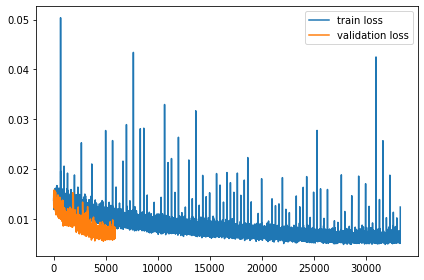

In [73]:
import matplotlib.pyplot as plt

plt.plot(training_loss, label = "train loss")
plt.plot(validation_loss, label = "validation loss")
plt.tight_layout()
plt.legend()


## Evaluation

1. Sample 36 random samples from testset (your own dataset class)
2. Give each of the 36 samples to your trained model and get the outputs
3. Visualize `input` (black-and-white image), `output` (output of the model with the given black-and-white input image) and `ground truth` (the actual RGB image)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


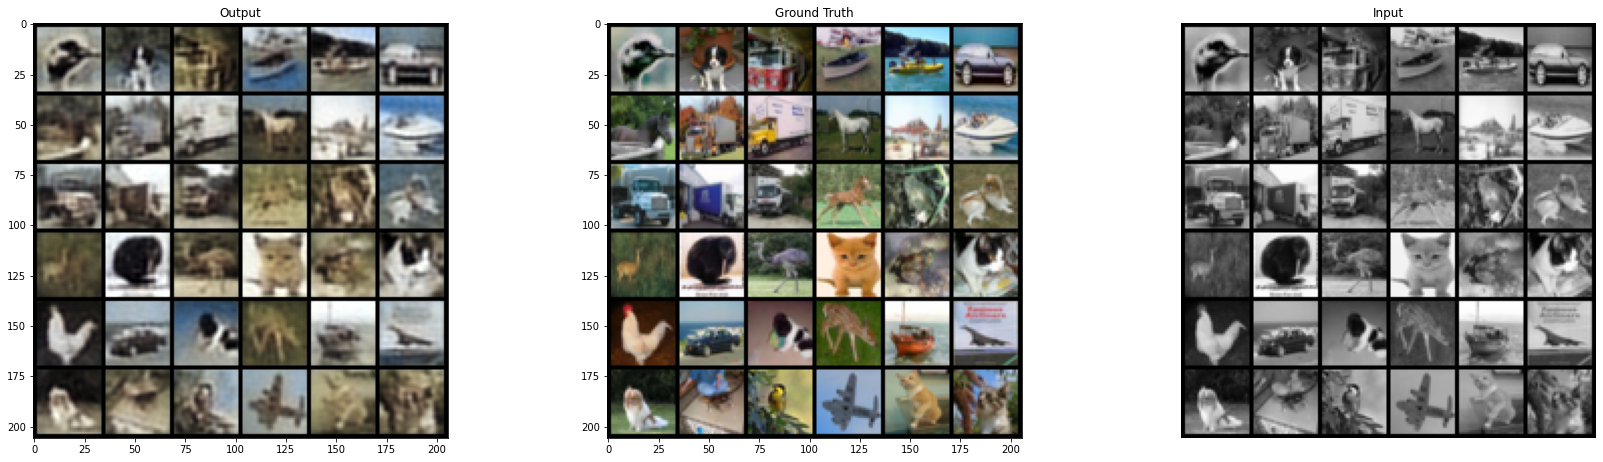

In [80]:
import torchvision.utils
import matplotlib.pyplot as plt

test_colorfull_images = []
predicted_colorfulls = []

with torch.no_grad():
    image_inds = np.random.choice(len(testset), 36, replace=False)
    bw_images = torch.stack([testset[i][1] for i in image_inds])
    bw_images = bw_images.to(device)
    predicted_colorfull_images = cn(bw_images).cpu()
    bw_images = bw_images.cpu()

    for i in range(36):
        img = np.transpose(testset[image_inds[i]][0].numpy().astype('float64'), (1, 2, 0))
        test_colorfull_images.append(torch.FloatTensor(np.transpose(img, (2, 0, 1))))
        predicted_img = predicted_colorfull_images[i].numpy().astype('float64')
        predicted_colorfulls.append(torch.FloatTensor(predicted_img))


    _, plts = plt.subplots(figsize=(60, 90))
    plt.subplot(10, 6, 1)
    plt.imshow(np.transpose(torchvision.utils.make_grid(torch.stack(predicted_colorfulls), nrow=6).numpy(), (1, 2, 0)))
    plt.title('Output')
    plt.subplot(10, 6, 2)
    plt.imshow(np.transpose(torchvision.utils.make_grid(torch.stack(test_colorfull_images), nrow=6).numpy(), (1, 2, 0)))
    plt.title('Ground Truth')
    plt.subplot(10, 6, 3)
    plt.imshow(np.transpose(torchvision.utils.make_grid((bw_images), nrow=6).numpy(), (1, 2, 0)))
    plt.title('Input')
    plt.axis('off')
    plt.show()
